## Multi Layer Perceptron
Multi-layer perceptron is a type of network where multiple layers of a group of perceptron are stacked together to make a model.

### 1. Perceptron
In our case perceptron is a linear model which takes a bunch of inputs multiply them with weights and add a bias term to generate an output.

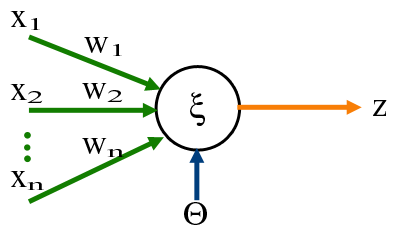

If we stack a bunch of these perceptrons together, it becomes a hidden layer which is also known as a Dense layer


Note that bias term is now a vector and W is a weight matrix
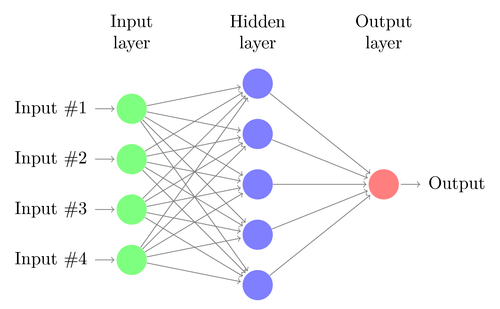


Now we understand dense layer let’s add a bunch of them, and that network becomes a multi-layer perceptron network.

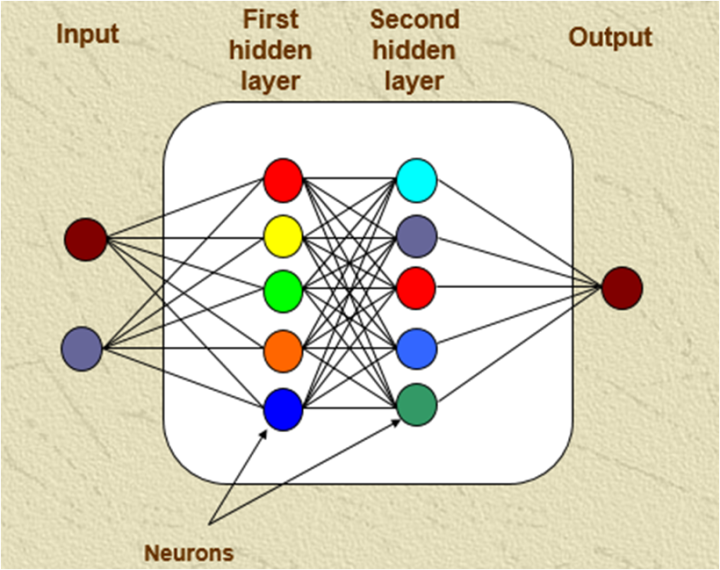

### 2. Activation Function</b> 

As we want our MLP to be flexible and learn non-linear decision boundaries, we also need to introduce non-linearity into the network. We achieve the task of introducing non-linearity by adding activation function. 

1. ReLU Activation
    ReLU function is a simple function which is zero for any input value below zero and the same value for values greater than zero.


### 3. Training the Network
For training a neural network we need to have a loss function and every layer should have a feed-forward loop and backpropagation loop. 

Feedforward loop takes an input and generates output for making a prediction and backpropagation loop helps in training the model by adjusting weights in the layer to lower the output loss. 

In backpropagation, the weight update is done by using backpropagated gradients using the chain rule and optimized using an optimization algorithm. In our case, we will be using SGD(stochastic gradient descent)

In [1]:
import numpy as np
np.random.seed(1337)

In [2]:
class Layer:
    def __init__(self):
        super(Layer, self).__init__()
    
    def forward(self, x):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        
        # Dummy layer returns input
        return x
    
    def backward(self, x, grad_output):
        '''
        Performs a backpropagation step through the layer, with respect to the given input.
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        The gradient of a dummy layer is precisely grad_output
        '''
        num_units = x.shape[1]
        dl_dx = np.eye(num_units) # => d_layer_d_x
        
        return np.dot(grad_output, dl_dx)

In [3]:
# ReLU 
class ReLU(Layer):
    def __init__(self):
        # It applies elementwise ReLU to all x
        pass
    
    def forward(self, x):
        relu_x = np.maximum(x, 0)
        return relu_x
    
    def backward(self, x, grad_output):
        # Compute grad of loss w.r.t ReLU
        relu_grad = (x > 0)
        return grad_output * relu_grad

### Dense Layer
A dense layer applies affine transformation. In a vectorized form, it can be described as:


Where
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs]
* and b is a vector of num_outputs biases.

In [17]:
class Dense(Layer):
    def __init__(self, x, out, lr=0.1):
        # x -> input, out => output units
        # A dense layer is a layer which performs a learned affine transformation
        # f(x) = <W*x> + b
        
        self.lr = lr
        # In Dense layer Xavier initialization is used where it’s 
        # initializing the weights in your network by drawing them from a 
        # distribution with zero mean and a specific variance
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(2/(x+out)), size=(x,out))
        self.biases = np.zeros(out)
    
    def forward(self, x):
        # Perform affine Transformation
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        return np.dot(self.weights, x) + self.biases
    
    def backward(self, x, grad_output):
        # Compute df/dx = df/d(dense) * d(dense)/dx (Chain Rule)
        # d(dense)/dx = weights.Transposed
        grad_x = np.dot(grad_output, self.weights.T) # Gradient Input
        
        # Compute Gradient w.r.t weights and biases
        grad_weights = np.dot(x.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * x.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape # Check Shapes
        
        # Perform SGD optimization
        self.weights -= self.lr*grad_weights
        self.biases -= self.lr*grad_biases
        
        return grad_output

## Loss Function
To Predict Probabilities,

It would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities.

Crossentropy as a F(x) of softmax
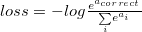

Using a better version of this will be <code>Log-Softmax</code>


In [5]:
def softmax_crossentropy(logits, reference_ans):
    # Compute crossentropy from the logits[batches, n_classes] and ids of correct answers
    a_correct = logits[np.arange(len(logits)), reference_ans]
    
    loss = -a_correct + np.log(np.sum(np.exp(logits), axis=-1))
    
    return loss

def grad_softmax_crossentropy(logits, ref_ans):
    # Compute crossentropy gradient from logits[batch, n_classes] and ids of correct answers
    ones_for_ans = np.zeros_like(logits)
    ones_for_ans[np.arange(len(logits)), ref_ans] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    
    return (-ones_for_ans + softmax) / logits.shape[0]

## Load Data

In [7]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt

%matplotlib inline

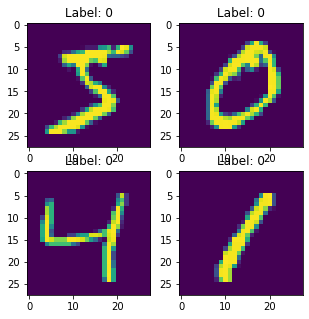

In [10]:
def load(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    
    X_train = X_train.astype(np.float32) / 255.0
    y_train = y_train.astype(np.float32) / 255.0
    
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load(flatten=True)

plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title('Label: %i'%y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]))

## Neural Network

In [11]:
model = []
model.append(Dense(X_train.shape[1], 100))
model.append(ReLU())
model.append(Dense(100, 200))
model.append(ReLU())
model.append(Dense(200, 10))

# Forward Pass
def forward(model, x):
    # x => input
    # Compute Activations of all the layers sequentially
    # Return Activations for each layer 
    activations = []
    
    # Iterate through the Model
    for layer in model:
        activations.append(layer.forward(x))
        # Updating x to the last layer output
        x = activations[-1]
    
    assert len(activations) == len(model)
    return activations

def predict(model, x):
    # Compute the predictions by returning the index of largest Logit probability 
    logits = forward(model, x)[-1]
    return logits.argmax(axis=-1)

In [13]:
# Train Function
def train(model, X, y):
    # Train on X and y
    # Run a Forward Pass to get all layer activations
    # Then run backprop from last to the first layer
    
    # After backprop of all layers, the Dense layers would have already made one Gradient Step
    
    layer_activations = forward(model, X)
    layer_inputs = [X] + layer_activations 
    # layer_input[i] is the input for model[i]
    logits = layer_activations[-1]
    
    # Compute the loss and initial gradient
    loss = softmax_crossentropy(logits, y)
    loss_grad = grad_softmax_crossentropy(logits, y)
    
    # Propogate Gradients through the Neural Net
    # reverse propogation as it is BackPropogation
    for layer_index in range(len(model))[::-1]:
        layer = model(layer_index)
        
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t input, also weight updates (x => input)
        
    return np.mean(loss)

In [ ]:
# Training Loop
from tqdm import trange
from IPython.display import clear_output

def iterate_batch(inputs, targets, BS, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    
    for start_idx in trange(0, len(inputs) - BS + 1, BS): # BS => BatchSize
        if shuffle:
            excerpt = indices[start_idx:start_idx + BS]
        else:
            excerpt = slice(start_idx, start_idx + BS)
        
        yield inputs[excerpt], targets[excerpt] # yield is used as in for (Lazy Python)😎

train_log = []
val_log = []

for epoch in range(25):
    for x_batch, y_batch in iterate_batch(X_train, y_train, BS=32, shuffle=True):
        train(model, x_batch, y_batch)
    
    train_log.append(np.mean(predict(model, X_train) == y_train))
    val_log.append(np.mean(np.mean(predict(model, X_val) == y_val)))
    clear_output()
    #print('Epoch', epoch)
    trange.set_description('Epoch: '%epoch)
    trange.set_description('Train Accuracy: '%train_log[-1])
    trange.set_description('Val Accuracy: '%val_log[-1])
    plt.plot(train_log, label='Train Accuracy')
    plt.plot(val_log, label='Val Accuracy')
    plt.legend(loc='best')
    plt.show()